In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

import data_utils.data_analysis as data_analysis
import models.tools as models_tools
import models.rf as rf

In [2]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

In [3]:
#Average shots with same input param
def shot_average(df_input,df_time):
    goodness_list=[]
    o2_list=[]
    o3_list=[]
    o4_list=[]
    #wizz_list=[]
    goodness_mean=[]
    wizz_mean=[]
    #emax_std=[]
    counter=0
    for index,row in df_input.iterrows():
        o2=row['order2']
        o3=row['order3']
        o4=row['order4']
        #print(index)
        if(index==0):
            goodness_list.append(row['goodness'])
            wizz_list=df_time.iloc[index].to_numpy()
            #print(wizz_list)
            counter=1
        if(index>0):
            o2_prev=df_input['order2'].iloc[index-1]
            o3_prev=df_input['order3'].iloc[index-1]
            o4_prev=df_input['order4'].iloc[index-1]
            if(o2==o2_prev and o3==o3_prev and o4==o4_prev):
                counter+=1
                goodness_list.append(row['goodness'])
                wizz_list=np.vstack([wizz_list,df_time.iloc[index].to_numpy()])
                #print(wizz_list)
                #ecut_list.append(df_metrics['Cutoff E'].iloc[index])
                #integ_list.append(df_metrics['Integr norm'].iloc[index])
            else:
                #do the avg (from the previous shots)
                goodness_mean.append(np.mean(goodness_list))
                wizz_mean.append(np.mean(wizz_list,axis=0))
                ##print(wizz_mean)
                ##print(counter)
                #emax_std.append(np.std(emax_list))
                #ecut_mean.append(np.mean(ecut_list))
                #ecut_std.append(np.std(ecut_list))
                o2_list.append(o2_prev)
                o3_list.append(o3_prev)
                o4_list.append(o4_prev)
                
                #AND start the new batch
                goodness_list=[row['goodness']]
                wizz_list=df_time.iloc[index].to_numpy()
                #ecut_list=[df_metrics['Cutoff E'].iloc[index]]
                #integ_list=[df_metrics['Integr norm'].iloc[index]]
                #print(counter)
                counter=1
            #print(counter)

    df_input_avg=pd.DataFrame()
    df_time_avg=pd.DataFrame(wizz_mean)
    df_input_avg['order2']=o2_list
    df_input_avg['order3']=o3_list
    df_input_avg['order4']=o4_list
    df_input_avg['goodness mean']=goodness_mean
    #df_metrics_avg['Emax std']=emax_std
    return df_input_avg,df_time_avg

In [4]:
#get the spectral coeeficients (as in the get shot num)
def get_coef(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    order2=df_input['order2'].loc[id_value]
    order3=df_input['order3'].loc[id_value]
    order4=df_input['order4'].loc[id_value]
    return order2, order3, order4

In [5]:
filename='datasets/galadriel_dataset_24_09_18.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
      shot number   order2   order3     order4  goodness
0          163165  34400.0 -23000.0 -5500000.0  0.945039
1          163166  34400.0 -23000.0 -5500000.0  0.862834
2          163167  34400.0 -23000.0 -5500000.0  0.834347
3          163168  34400.0 -23000.0 -5500000.0  0.873099
4          163169  34400.0 -23000.0 -5500000.0  0.851336
...           ...      ...      ...        ...       ...
9498       172664  35400.0  28000.0 -4000000.0  1.031447
9499       172665  35400.0  28000.0 -4000000.0  1.031718
9500       172666  35400.0  28000.0 -4000000.0  1.009015
9501       172667  35400.0  28000.0 -4000000.0  1.199801
9502       172668  35400.0  28000.0 -4000000.0  1.241150

[9503 rows x 5 columns]
----
Time values
0    -104.962227
1     -94.466005
2     -83.969782
3     -73.473559
4     -62.977336
5     -52.481114
6     -41.984891
7     -31.488668
8     -20.992445
9     -10.496223
10      0.000000
11     10.496223
12     20.992445
13     31.488668
14     41.984891
15     52.

In [28]:
df_input.describe()

,shot number,order2,order3,order4,goodness
count,9503.000000,9503.000000,9503.000000,9.503000e+03,9503.000000
mean,167916.696412,34900.021046,2500.789224,-4.749921e+06,1.185132
std,2743.790366,316.254388,15565.830169,5.123437e+05,0.217978
min,163165.000000,34400.000000,-23000.000000,-5.500000e+06,0.663816
25%,165540.500000,34600.000000,-11000.000000,-5.200000e+06,1.024159
50%,167917.000000,34900.000000,4000.000000,-4.600000e+06,1.135635
75%,170292.500000,35200.000000,16000.000000,-4.300000e+06,1.345186
max,172668.000000,35400.000000,28000.000000,-4.000000e+06,1.941571


### AVerage the shots with the same input param

In [6]:
df_input_avg,df_time_avg=shot_average(df_input,df_time)

In [7]:
df_input_avg

,order2,order3,order4,goodness mean
0,34400.0,-23000.0,-5500000.0,0.863652
1,34400.0,-23000.0,-5200000.0,0.969892
2,34400.0,-23000.0,-4900000.0,1.197340
3,34400.0,-23000.0,-4600000.0,1.265565
4,34400.0,-23000.0,-4300000.0,1.102407
...,...,...,...,...
1182,35400.0,28000.0,-5500000.0,1.048083
1183,35400.0,28000.0,-5200000.0,1.017359
1184,35400.0,28000.0,-4900000.0,0.974364
1185,35400.0,28000.0,-4600000.0,0.957133


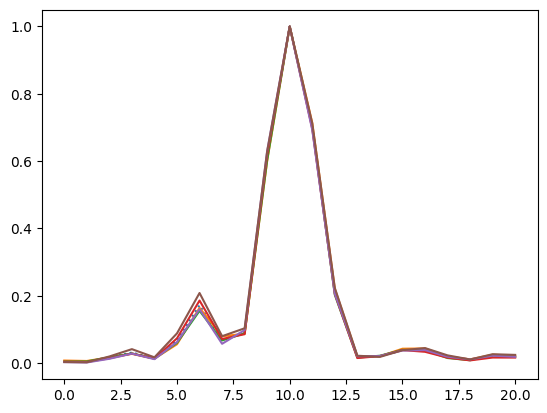

In [8]:
plt.plot(df_time_avg.iloc[0],linestyle=':')
plt.plot(df_time.iloc[0])
plt.plot(df_time.iloc[1])
plt.plot(df_time.iloc[2])
plt.plot(df_time.iloc[3])
plt.plot(df_time.iloc[4])

### Drop shots (in the avg) with bad goodness

In [9]:
df_input_reduced=df_input_avg[df_input_avg['goodness mean']>1.1]

In [10]:
good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_time_reduced=df_time_avg.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_time_reduced.reset_index(inplace=True,drop=True)

In [11]:
df_input_reduced

,order2,order3,order4,goodness mean
0,34400.0,-23000.0,-4900000.0,1.197340
1,34400.0,-23000.0,-4600000.0,1.265565
2,34400.0,-23000.0,-4300000.0,1.102407
3,34400.0,-20000.0,-4900000.0,1.319798
4,34400.0,-20000.0,-4600000.0,1.391051
...,...,...,...,...
681,35400.0,22000.0,-4300000.0,1.133053
682,35400.0,22000.0,-4000000.0,1.100280
683,35400.0,25000.0,-5500000.0,1.105975
684,35400.0,25000.0,-5200000.0,1.177654


# TRAIN THE FORWARD MODEL

In [12]:
def train_forward(df_input,df_time):
    #split the dataset (X:dazzler param, Y:wizzler)
    X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf,df_error_forward_rf

In [13]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

In [14]:
forward_model_rf,df_error_forward_rf=train_forward(df_input,df_time)

In [15]:
y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

### Plot a prediction

In [16]:
def plot_example(shot_index,y_test,y_test_reset,df_input,df_time_val,
                 y_predict_forward):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=get_coef(shot_index,y_test,df_input)
    
    plt.plot(df_time_val,y_test_reset.loc[shot_index],label='Test (shot #'+str(shot_numb)+')',linewidth=3)
    #plt.plot(df_time_val,y_predict_lin_backforw[shot_index],label='Prediction (Linear)')
    plt.plot(df_time_val,y_predict_forward[shot_index],label='Prediction (Random  Forest)',linewidth=3,linestyle='--')

    mae='{:6.2f}'.format(100*mean_absolute_error(y_test_reset.loc[shot_index],y_predict_forward[shot_index]))
    plt.title('Mean abs. error:'+mae+'%',fontsize=14)
    plt.text(35, 0.7, r'$\beta^2=$'+str(order2), dict(size=14))
    plt.text(35, 0.6, r'$\beta^3=$'+str(order3), dict(size=14))
    plt.text(35, 0.5, r'$\beta^4=$'+str(order4), dict(size=14))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

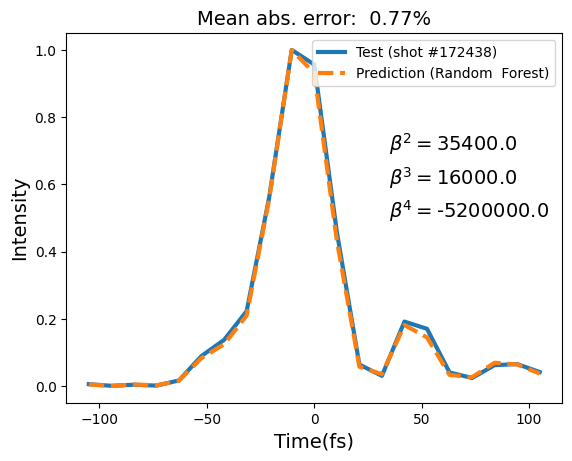

In [17]:
shot_index=25
plot_example(shot_index,y_test,y_test_reset,df_input,df_time_val,y_predict_forward)

### TRain model with the average shots

In [18]:
#split the dataset (X:dazzler param, Y:wizzler)
X_avg_train, X_avg_test, y_avg_train, y_avg_test=models_tools.split_dataset_roundtrip(df_input_avg,df_time_avg,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_avg_test_reset=y_avg_test.reset_index(drop=True)

In [19]:
forward_model_rf_avg,df_error_forward_rf_avg=train_forward(df_input_avg,df_time_avg)

In [20]:
y_predict_forward_avg=rf.make_rf_prediction(forward_model_rf_avg,X_avg_test)

### Train model with good goodness shots

In [21]:
#split the dataset (X:dazzler param, Y:wizzler)
X_red_train, X_red_test, y_red_train, y_red_test=models_tools.split_dataset_roundtrip(df_input_reduced,df_time_reduced,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_red_test_reset=y_red_test.reset_index(drop=True)

In [22]:
forward_model_rf_red,df_error_forward_rf_red=train_forward(df_input_reduced,df_time_reduced)

In [23]:
y_predict_forward_red=rf.make_rf_prediction(forward_model_rf_red,X_red_test)

Text(0.5, 1.0, 'RF Model Accuracy')

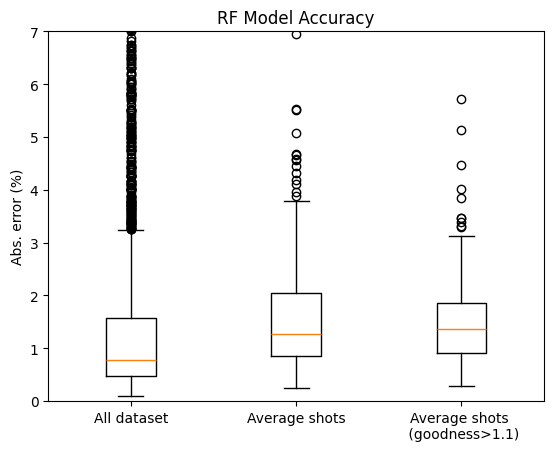

In [24]:
error_dist=[100*df_error_forward_rf,
           100*df_error_forward_rf_avg,
           100*df_error_forward_rf_red]
labels=['All dataset','Average shots','Average shots \n (goodness>1.1)']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,7)
plt.ylabel('Abs. error (%)')
plt.title('RF Model Accuracy')

9500 shots > 70% training   30% testing

1180 shots

686 shots

## Goodness

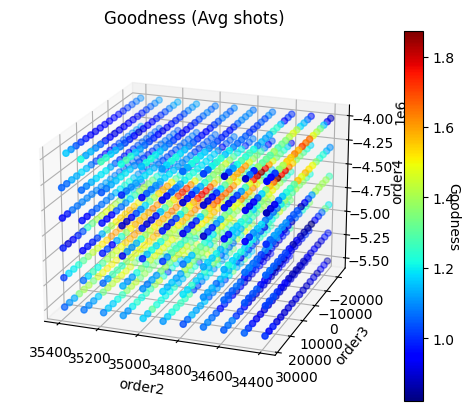

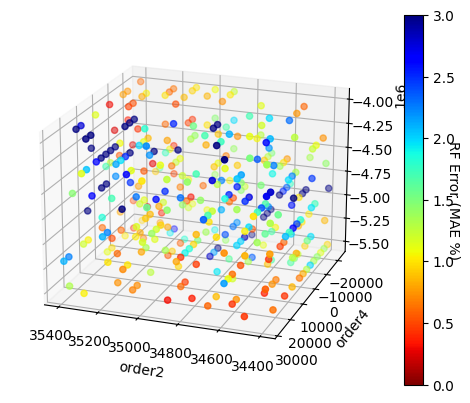

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plot_3d= ax.scatter(df_input_avg['order2'], df_input_avg['order3'], df_input_avg['order4'],c=df_input_avg['goodness mean'],cmap='jet')
ax.set_xlabel('order2')
ax.set_ylabel('order3')
ax.set_zlabel('order4')
ax.view_init(elev=20., azim=110)
plt.title('Goodness (Avg shots)')
cbar = plt.colorbar(plot_3d)
cbar.ax.set_ylabel('Goodness', rotation=270)
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(projection='3d')
plot_3d_2= ax2.scatter(X_avg_test['order2'], X_avg_test['order3'], X_avg_test['order4'],c=100*df_error_forward_rf_avg,
                       cmap='jet_r',vmin=0, vmax=3)
ax2.set_xlabel('order2')
ax2.set_ylabel('order3')
ax2.set_ylabel('order4')
ax2.view_init(elev=20., azim=110)
#plt.title('Goodness')
cbar2 = plt.colorbar(plot_3d_2)
cbar2.ax.set_ylabel('RF Error (MAE %)', rotation=270)
plt.show()

In [26]:
#plot goodness vs ML error  (from the AVG case)
#(ML error has the same index order as y_test/x_test)
#First create the goodness array. Get the indexes from x_test and select those shots in the df_input_avg
avg_shots_list=X_avg_test.index.values
goodness_avg=df_input_avg['goodness mean'].iloc[avg_shots_list]
#and reset the Series because the error starts at 0 (but was using same order as X_test_avg)
goodness_avg.reset_index(inplace=True,drop=True)

Text(0.5, 1.0, 'Prediction error vs goodness for avg shots')

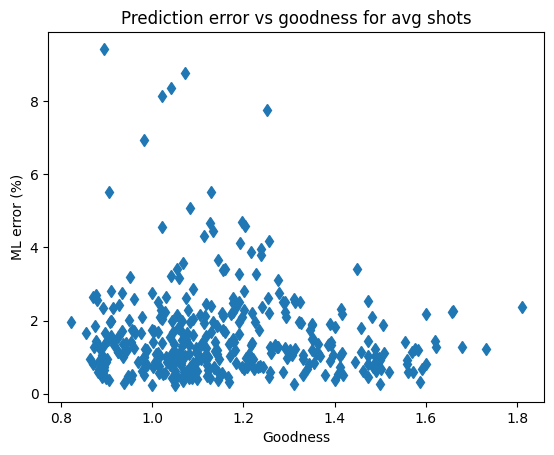

In [27]:
plt.plot(goodness_avg,100*df_error_forward_rf_avg,linestyle='None',marker='d')
plt.xlabel('Goodness')
plt.ylabel('ML error (%)')
plt.title('Prediction error vs goodness for avg shots')